In [4]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import bz2

embedding_dim = 100
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1600#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1



In [5]:
def processbz2data(filename):
    

    bz2datalist = []
    with bz2.open(filename, "rb") as f:
        # Decompress data from file
        for line in f:
            #print(line)
            line = str(line)
            onereview = line.split('__label__')
            #print(onereview)
            fullreviewstring = onereview[1]
            reviewlabel = fullreviewstring[0]
            reviewstring = str(fullreviewstring[1:])
            #print(reviewlabel)
            #print(reviewstring)
            bz2datalist.append((reviewlabel,reviewstring))
    bz2datadf = pd.DataFrame(bz2datalist,columns = ['label','reviewtext'])            
    return bz2datadf

In [78]:
mydataset = pd.read_csv('training_cleaned.csv', header=0, names=['label','somecol','timeoftweet', 'weirdcol', 'whotweeted', 'tweettext'])
#mydatasetnoheader = pd.read_csv('training_cleaned.csv')

In [6]:
mydata = processbz2data('train.ft.txt.bz2')

In [7]:
mydata.head(10)

,label,reviewtext
0,2,Stuning even for the non-gamer: This sound tr...
1,2,The best soundtrack ever to anything.: I'm re...
2,2,Amazing!: This soundtrack is my favorite musi...
3,2,Excellent Soundtrack: I truly like this sound...
4,2,"Remember, Pull Your Jaw Off The Floor After H..."
5,2,an absolute masterpiece: I am quite sure any ...
6,1,"Buyer beware: This is a self-published book, ..."
7,2,Glorious story: I loved Whisper of the wicked...
8,2,A FIVE STAR BOOK: I just finished reading Whi...
9,2,Whispers of the Wicked Saints: This was a eas...


In [79]:
mydataset.head(10)

,label,somecol,timeoftweet,weirdcol,whotweeted,tweettext
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [80]:
mydataset[mydataset['label'] !=0]

,label,somecol,timeoftweet,weirdcol,whotweeted,tweettext
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
#totalrows = mydataset.shape[0]
#print(totalrows)
#shuffled = mydataset.sample(random_state=4, n=totalrows)
totalrows = mydata.shape[0]
print(totalrows)
shuffled = mydata.sample(random_state=4, n=totalrows)

3600000


In [9]:
shuffled.head(10)

,label,reviewtext
209260,2,Good CB: The radio works as advertised. Clear...
59068,2,Charming escapist escapist chick lit: The deb...
1307912,2,I Loved this book: This book was a very fast ...
916790,1,This watch has satin strap!: The watch is pre...
331466,2,Best on the market: I picked this up from Who...
38788,1,Worthless....Sank Faster Than The Titanic: Th...
803465,2,Nights in Rodanthe: I received the movie Nigh...
972164,1,Shocked at my disappointment.: Was very supri...
2320044,2,"Fun, simple, game!: This game is a lot of fun..."
1461522,2,"Lighter...Brighter... Man, I could go on and ..."


In [10]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    embeddings_index = {}
    with open(gloveFile,'rb') as f:
        for line in f:
            values = line.split();
            word = values[0];
            coefs = np.asarray(values[1:], dtype='float32');
            embeddings_index[word] = coefs;
    return embeddings_index

In [11]:
embeddingdict = loadGloveModel('glove.twitter.27B\glove.twitter.27B.100d.txt')

Loading Glove Model


In [30]:
print(len(embeddingdict))
count=0
for key, value in embeddingdict.items():
    print(key)
    #print(value)
    count = count+1
    if(count>50):
        break
print(embeddingdict[b'love'])
print(embeddingdict[b'adore'])

1193514
b'<user>'
b'.'
b':'
b'rt'
b','
b'<repeat>'
b'<hashtag>'
b'<number>'
b'<url>'
b'!'
b'i'
b'a'
b'"'
b'the'
b'?'
b'you'
b'to'
b'('
b'<allcaps>'
b'<elong>'
b')'
b'me'
b'de'
b'<smile>'
b'\xef\xbc\x81'
b'que'
b'and'
b'\xe3\x80\x82'
b'-'
b'my'
b'no'
b'\xe3\x80\x81'
b'is'
b'it'
b'\xe2\x80\xa6'
b'in'
b'n'
b'for'
b'/'
b'of'
b'la'
b"'s"
b'*'
b'do'
b"n't"
b'that'
b'on'
b'y'
b"'"
b'e'
b'o'
[-4.8371e-01 -2.7318e-01 -4.6840e-02  7.0274e-01 -5.6301e-01 -1.7214e-01
  8.1775e-01 -6.6641e-02  2.0224e-02 -2.3878e-01 -1.6122e-02 -1.7875e-01
 -4.9281e+00 -4.0272e-01 -4.1190e-01 -1.4570e-01  1.8508e-01 -1.9116e-01
 -8.4608e-01  6.5378e-01  1.2370e-01  4.8835e-02 -3.3709e-01  2.5834e-01
  4.7729e-01 -8.8145e-01 -1.3083e-01  7.9499e-01  8.6216e-02 -9.1803e-01
 -9.6671e-01 -4.8309e-01 -4.0963e-01  1.6920e-01  2.3241e-01 -2.0524e-02
  2.2267e-01 -2.6763e-01  1.4378e-01 -4.6547e-02 -1.1726e+00 -3.5298e-02
  2.8347e-01  4.3446e-01  1.8472e-01  3.3065e-01  6.7848e-02 -7.6485e-01
  1.8351e-01 -6.4361e-01 -7.5

In [16]:
#shuffled['newlabel'] = np.where(shuffled['label'] == 4,1,0)
shuffled['newlabel'] = np.where(shuffled['label'] == '1',0,1)
shuffled.head(10)

,label,reviewtext,newlabel
209260,2,Good CB: The radio works as advertised. Clear...,1
59068,2,Charming escapist escapist chick lit: The deb...,1
1307912,2,I Loved this book: This book was a very fast ...,1
916790,1,This watch has satin strap!: The watch is pre...,0
331466,2,Best on the market: I picked this up from Who...,1
38788,1,Worthless....Sank Faster Than The Titanic: Th...,0
803465,2,Nights in Rodanthe: I received the movie Nigh...,1
972164,1,Shocked at my disappointment.: Was very supri...,0
2320044,2,"Fun, simple, game!: This game is a lot of fun...",1
1461522,2,"Lighter...Brighter... Man, I could go on and ...",1


In [17]:
#sentences = shuffled['tweettext'].values
sentences = shuffled['reviewtext'].values
labels =  shuffled['newlabel'].values
totalrows

3600000

In [18]:
training_size = totalrows
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length)

split = int(test_portion * training_size)

traininglast = training_size - split

test_sequences = np.array(padded[traininglast:training_size])
training_sequences = np.array(padded[0:traininglast])
test_labels = np.array(labels[traininglast:training_size])
training_labels = np.array(labels[0:traininglast])


In [19]:
print(test_sequences.shape)
print(training_sequences.shape)
print(test_labels.shape)
print(training_labels.shape)
print(vocab_size)
#embeddingdict[stringtolookfor.encode('utf-8')]

(360000, 40)
(3240000, 40)
(360000,)
(3240000,)
1083356


In [20]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
wordsnotfound=0
for word, i in word_index.items():
    wordtofind = word.encode('utf-8')
    embedding_vector = embeddingdict.get(wordtofind)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
    else:
        wordsnotfound = wordsnotfound + 1
print('{0} words not found'.format(str(wordsnotfound)))
print(embeddings_matrix.shape)

906624 words not found
(1083357, 100)


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           108335700 
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 108,465,621
Trainable params: 129,921
Non-trainable params: 108,335,700
_________________________________________________________________


In [22]:

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")

Train on 3240000 samples, validate on 360000 samples
Epoch 1/10
3240000/3240000 [==============================] - 2924s 902us/sample - loss: 0.2911 - accuracy: 0.8736 - val_loss: 0.2504 - val_accuracy: 0.8956
Epoch 2/10
3240000/3240000 [==============================] - 2878s 888us/sample - loss: 0.2580 - accuracy: 0.8910 - val_loss: 0.2372 - val_accuracy: 0.9017
Epoch 3/10
3240000/3240000 [==============================] - 2906s 897us/sample - loss: 0.2516 - accuracy: 0.8942 - val_loss: 0.2334 - val_accuracy: 0.9034
Epoch 4/10
3240000/3240000 [==============================] - 2886s 891us/sample - loss: 0.2483 - accuracy: 0.8957 - val_loss: 0.2316 - val_accuracy: 0.9040
Epoch 5/10
3240000/3240000 [==============================] - 2855s 881us/sample - loss: 0.2463 - accuracy: 0.8968 - val_loss: 0.2296 - val_accuracy: 0.9055
Epoch 6/10
3240000/3240000 [==============================] - 2817s 870us/sample - loss: 0.2449 - accuracy: 0.8975 - val_loss: 0.2283 - val_accuracy: 0.9061
Epoch

<Figure size 432x288 with 0 Axes>

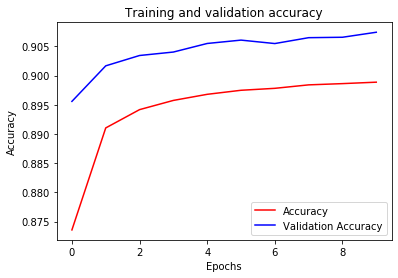

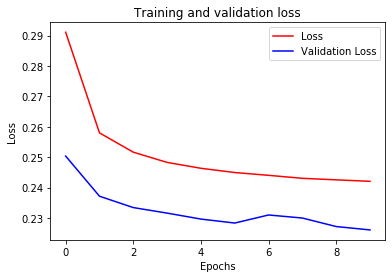

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [24]:
model.save('sentimentdetectmodel0421.h5')

In [25]:
import io
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer0421.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [99]:
with open('tokenizer.json') as f:
    data = json.load(f)
    ntokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [111]:
testsentences = ['it was very good', 'i love my family', 'it was not very good'
                 ,'I would go with something that is better quality than this one'
                 ,'i do not love ui work', ' i adore you'
                ]
testsequences = ntokenizer.texts_to_sequences(testsentences)
testpadded = pad_sequences(testsequences, maxlen=max_length)
answer = model.predict(testpadded)
answer

array([[0.9720116 ],
       [0.9594597 ],
       [0.01909702],
       [0.8554401 ],
       [0.07427577],
       [0.8987194 ]], dtype=float32)

In [112]:
tf.__version__

'2.1.0'

In [113]:
tf.keras.__version__

'2.2.4-tf'

In [1]:
import bz2

In [30]:
mydata = processbz2data('train.ft.txt.bz2')

In [31]:
mydata.shape[0]

3600000

In [32]:
mydatatest = processbz2data('test.ft.txt.bz2')

In [33]:
mydatatest.shape[0]

400000

In [38]:
mydata.head(10)

,label,reviewtext
0,2,Stuning even for the non-gamer: This sound tr...
1,2,The best soundtrack ever to anything.: I'm re...
2,2,Amazing!: This soundtrack is my favorite musi...
3,2,Excellent Soundtrack: I truly like this sound...
4,2,"Remember, Pull Your Jaw Off The Floor After H..."
5,2,an absolute masterpiece: I am quite sure any ...
6,1,"Buyer beware: This is a self-published book, ..."
7,2,Glorious story: I loved Whisper of the wicked...
8,2,A FIVE STAR BOOK: I just finished reading Whi...
9,2,Whispers of the Wicked Saints: This was a eas...
